In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# Importing all packages from the fastai.vision library
from fastai.vision import *

In [0]:
# This cell can be run when I need to delete the folders and files I have created
# only run this if you need to restart your images
import shutil

shutil.rmtree('data')

## Downloading Images to classify


Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

In Google Chrome press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd> on Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>j</kbd> on macOS, and a small window the javascript 'Console' will appear. In Firefox press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd> on Windows/Linux or <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>k</kbd> on macOS. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl')).filter(u => !!u);
window.open('data:text/csv;name=urls.csv;charset=utf-8,' + escape(urls.join('\n')));
```

In [0]:
# Updating the classes of images to be classified
classes = ['daffodil', 'rose', 'tulip', 'iris', 'daisy', 'hyacinth']

In [0]:
# updating the list of the url file names
url_files = ['urls_daffodil.csv', 'urls_rose.csv', 'urls_tulip.csv', 'urls_iris.csv', 'urls_daisy.csv', 'urls_hyacinth.csv' ]

In [0]:
# defining a for loop to create a folder for each classes in the flowers folder

for c in classes:
  folder = c
  path = Path('data/flowers')
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)

## Uploading url files

Now that the folders have been created for each classes, upload the url files for each class into the flowers folder

In [0]:
# downloading 200 imaes for each class using the url file
# and adding them to the previously created folder

for c, u in zip(classes, url_files):
  folder = c
  file = u
  path = Path('data/flowers')
  dest = path/folder
  download_images(path/file, dest, max_pics=200)

In [0]:
# Checking all images that were downloaded can be opened
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

daffodil


rose


tulip


iris


daisy


hyacinth


In [0]:
# setting random seed to 42 - the answer to life, the universe and everything
np.random.seed(42)
# Create from imagenet style dataset/databunch object in path with training set 
# and validation set with an 80:20 split with all images normalised
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
# Confirming the classes in the data object
data.classes

['daffodil', 'daisy', 'hyacinth', 'iris', 'rose', 'tulip']

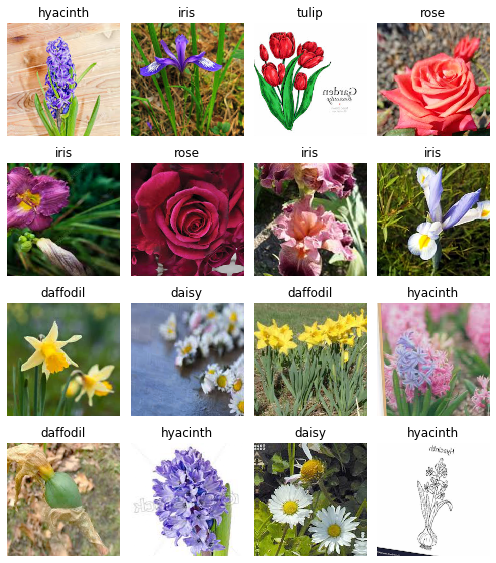

In [0]:
# Showing a sample of images of the batch 
data.show_batch(rows=4, figsize=(7,8))

In [0]:
# Confirming the class names, number of classes, length of the training and 
# validation datasets
# if done correctly with no issues with the images we should get a length of 
# 960 for the training dataset and 240 for the validation dataset
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['daffodil', 'daisy', 'hyacinth', 'iris', 'rose', 'tulip'], 6, 960, 240)

In [0]:
# instantiate the cnn_learner model for our data, with resnet34, 
# and error rate as the metric
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
# Fitting our model to the data with 4 epochs

learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.878643,0.500180,0.150000,05:49
1,1.081495,0.521813,0.129167,05:54
2,0.743337,0.513016,0.145833,05:51
3,0.555905,0.504422,0.141667,05:56


In [0]:
# Saving this version of our model
learn.save('stage_1')

In [0]:
# This is unfreezing the initial layers weights to train the model at a lower level
# than before.
# The initial layers are mostly used for understanding low-level features like 
# curves, lines, shapes, patterns. When we use pre-trained models they are trained 
# for identifying these features on a large dataset of images like Imagenet(1000 categories).

learn.unfreeze()

In [0]:
# Finding the learning rate of the model to help identify a parameter where the 
# model can be improved
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


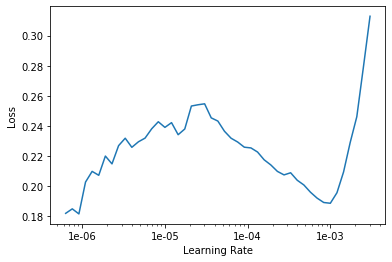

In [0]:
# Plotting the learning rate
learn.recorder.plot()

In [0]:
# Re-training the unfrozen model with 4 epochs and lr from 3e-4 to 3e-3
learn.fit_one_cycle(4, max_lr=slice(3e-4,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.304290,1.869452,0.279167,08:29
1,0.462963,3.131730,0.279167,08:32
2,0.423774,0.805260,0.145833,08:30
3,0.338514,0.392806,0.095833,08:26


In [0]:
# Saving this version of the model
learn.save('stage_2')


## Interpretation

In [0]:
# Loading the stage_2 version of the model
learn.load('stage_2')

Learner(data=ImageDataBunch;

Train: LabelList (960 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
hyacinth,hyacinth,hyacinth,hyacinth,hyacinth
Path: data/flowers;

Valid: LabelList (240 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
iris,rose,hyacinth,tulip,hyacinth
Path: data/flowers;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

In [0]:
# Createing an instance of ClassificationInterpretation. 
interp = ClassificationInterpretation.from_learner(learn)

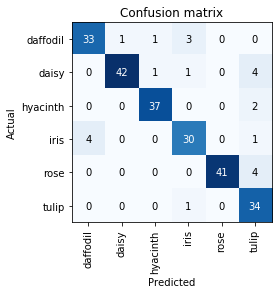

In [0]:
# Plotting the confusion matrix 
interp.plot_confusion_matrix()

In [0]:
# Calculating the top losses and indexing them
losses,idxs = interp.top_losses()
# Checking that the lengths of the validation dataset, all lose values, and indexes
# are equal
len(data.valid_ds)==len(losses)==len(idxs)

True

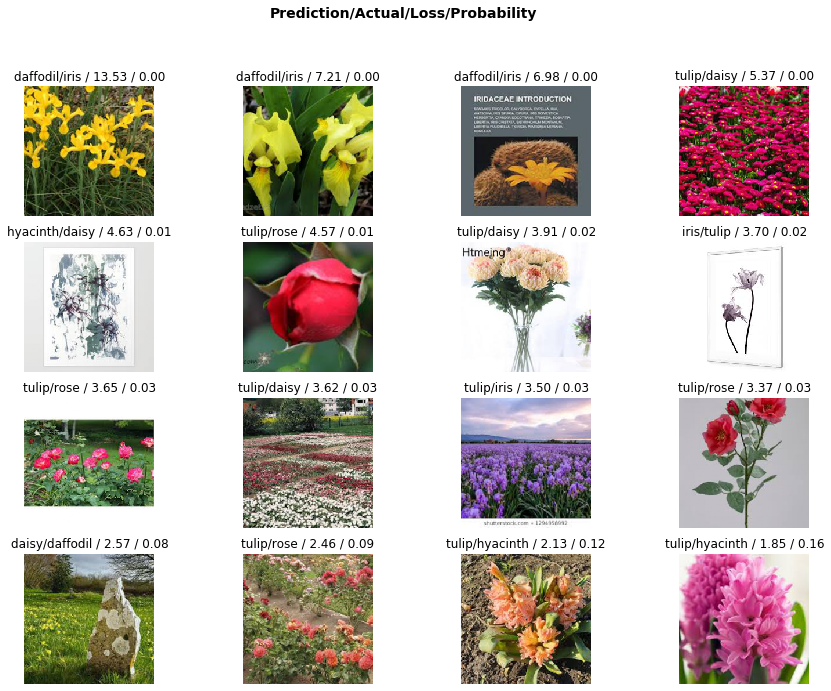

In [0]:
# Plotting the top 16 losses
interp.plot_top_losses(16, figsize=(15,11))